In [3]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import librosa

# Sklean
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# TensorFlow
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

filepath = 'C:/Users/aksha/Downloads/DataMusic/data.json'
with open(filepath, "r") as fp:
    data = json.load(fp)

# Define X nd y
X = np.array(data["mfcc"])
y = np.array(data["genre_num"])

from sklearn.model_selection import train_test_split

# Split the data into train (80%), validation (10%), and test (10%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42, stratify=y_train)

# Shape of the splits after optimization
print(f"X training data shape: {X_train.shape}, y training data shape: {y_train.shape}")
print(f"X validation data shape: {X_val.shape}, y validation data shape: {y_val.shape}")
print(f"X test data shape: {X_test.shape}, y test data shape: {y_test.shape}")


X training data shape: (6992, 132, 13), y training data shape: (6992,)
X validation data shape: (999, 132, 13), y validation data shape: (999,)
X test data shape: (1998, 132, 13), y test data shape: (1998,)


In [4]:
# Ensure proper CNN reshaping:
X_train_cnn = X_train[..., np.newaxis] # (samples, 132, 13, 1)
X_val_cnn = X_val[..., np.newaxis]
X_test_cnn = X_test[..., np.newaxis]

input_shape = (132, 13, 1)

# Confirm final shape for CNN:
print("\nCNN input shapes:")
print(f"X_train_cnn: {X_train_cnn.shape}")
print(f"X_val_cnn: {X_val_cnn.shape}")
print(f"X_test_cnn: {X_test_cnn.shape}")


CNN input shapes:
X_train_cnn: (6992, 132, 13, 1)
X_val_cnn: (999, 132, 13, 1)
X_test_cnn: (1998, 132, 13, 1)


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# CNN Optimized (V3 - Better accuracy potential)
model_cnn_v3 = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(132, 13, 1), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='same'),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='same'),
    Dropout(0.4),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='same'),
    Dropout(0.4),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='same'),
    Dropout(0.4),

    GlobalAveragePooling2D(),

    Dense(512, activation='relu'),
    Dropout(0.5),

    Dense(10, activation='softmax')
])

# Compile the model
model_cnn_v3.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
model_cnn_v3.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 132, 13, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 132, 13, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 66, 7, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 66, 7, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 66, 7, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 66, 7, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 33, 4, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 33, 4, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 33, 4, 256)     │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 33, 4, 256)     │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 17, 2, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 17, 2, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 17, 2, 256)     │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 17, 2, 256)     │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 9, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 9, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,099,274 (4.19 MB)

 Trainable params: 1,097,866 (4.19 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6, verbose=1)

history = model_cnn_v3.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=150,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Epoch 1/150
219/219 ━━━━━━━━━━━━━━━━━━━━ 28s 112ms/step - accuracy: 0.2691 - loss: 2.1387 - val_accuracy: 0.3443 - val_loss: 1.8008 - learning_rate: 1.0000e-04
Epoch 2/150
219/219 ━━━━━━━━━━━━━━━━━━━━ 24s 108ms/step - accuracy: 0.4413 - loss: 1.5406 - val_accuracy: 0.3784 - val_loss: 1.8266 - learning_rate: 1.0000e-04
Epoch 3/150
219/219 ━━━━━━━━━━━━━━━━━━━━ 25s 112ms/step - accuracy: 0.4992 - loss: 1.3531 - val_accuracy: 0.3834 - val_loss: 1.8520 - learning_rate: 1.0000e-04
Epoch 4/150
219/219 ━━━━━━━━━━━━━━━━━━━━ 24s 110ms/step - accuracy: 0.5499 - loss: 1.2345 - val_accuracy: 0.4034 - val_loss: 1.9790 - learning_rate: 1.0000e-04
Epoch 5/150
219/219 ━━━━━━━━━━━━━━━━━━━━ 25s 112ms/step - accuracy: 0.5826 - loss: 1.1715 - val_accuracy: 0.4685 - val_loss: 1.6869 - learning_rate: 1.0000e-04
Epoch 6/150
219/219 ━━━━━━━━━━━━━━━━━━━━ 25s 112ms/step - accuracy: 0.6220 - loss: 1.0819 - val_accuracy: 0.5205 - val_loss: 1.5178 - learning_rate: 1.0000e-04
Epoch 7/150
219/219 ━━━━━━━━━━━━━━━━━━━━

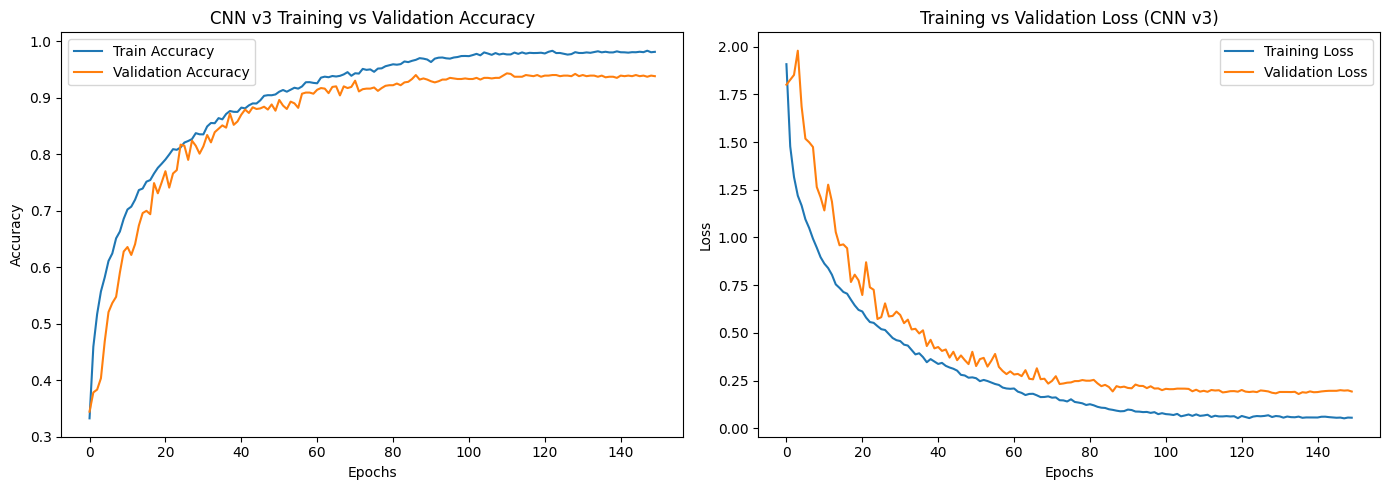

63/63 - 2s - 35ms/step - accuracy: 0.9444 - loss: 0.2026

CNN v3 Test Accuracy: 0.9444


In [12]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN v3 Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss (CNN v3)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate final accuracy on test set
test_loss, test_acc = model_cnn_v3.evaluate(X_test_cnn, y_test, verbose=2)
print(f"\nCNN v3 Test Accuracy: {test_acc:.4f}")


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Save your model
model_cnn_v3.save('cnn_music_genre_model_v3.h5')
print("✅ Model saved as 'cnn_music_genre_model_v3.h5'")
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 
          'jazz', 'metal', 'pop', 'reggae', 'rock']
# Prediction Function
def make_prediction_v3(model, X):
    preds_num = []
    preds_name = []
    for X_current in X:
        X_current = X_current[np.newaxis, ...]  # Add batch dimension
        pred = model.predict(X_current, verbose=0)
        pred_idx = np.argmax(pred, axis=1)[0]  # Predicted genre index
        preds_num.append(pred_idx)
        preds_name.append(genres[pred_idx])
    return preds_num, preds_name
# Make predictions
preds_num, preds_name = make_prediction_v3(model_cnn_v3, X_test_cnn)
print("✅ Predictions completed!")

# Plot confusion matrix
cm = confusion_matrix(y_test, preds_num)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genres)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')
plt.title('Confusion Matrix - CNN v3')
plt.show()


✅ Model saved as 'cnn_music_genre_model_v3.h5'
